### Training on whole trainset. No validation

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D,Dense

In [ ]:
local_file = "/content/drive/MyDrive/Winter_22/Adv_ML/mini_project_2/twitter_sentiments_data.csv/twitter_sentiments_data.csv"
#local_file="twitter_sentiments_data.csv"

df = pd.read_csv(local_file)
df = pd.DataFrame(df, columns=['target', 'tweet'])
df.head()

,target,tweet
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,"@nationwideclass no, it's not behaving at all...."
3,0,@Kwesidei not the whole crew
4,0,Need a hug


In [ ]:
eval_file = "/content/drive/MyDrive/Winter_22/Adv_ML/mini_project_2/twitter_sentiments_evaluation.csv/twitter_sentiments_evaluation.csv"
#eval_file="twitter_sentiments_evaluation.csv"

df_eval_og = pd.read_csv(eval_file)
eval_tweet_index = df_eval_og['tweet_index'].tolist()
df_eval = pd.DataFrame(df_eval_og, columns=['target', 'tweet'])
df_eval.head()

,target,tweet
0,NaN,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NaN,my whole body feels itchy and like its on fire
2,NaN,Doesnt want to leave i should just move here...
3,NaN,May máº¯n sáº½ Ä‘áº¿n bÃªn em mÃ khÃ´ng cÃ³ anh
4,NaN,@LOLTrish hey long time no see! Yes.. Rains a...


In [ ]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    sentence = remove_tags(sen)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [ ]:
X = []
sentences = list(df['tweet'])
for sen in sentences:
    X.append(preprocess_text(sen))
y=np.array(df['target'])

X_eval = []
sentences_eval = list(df_eval['tweet'])
for sen in sentences_eval:
    X_eval.append(preprocess_text(sen))
y_eval=np.array(df_eval['target'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_eval = tokenizer.texts_to_sequences(X_eval)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 124
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_eval = pad_sequences(X_eval, padding='post', maxlen=maxlen)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-12-17 11:08:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-17 11:08:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-17 11:08:38--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = np.zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(446879, 200)

In [ ]:
# model = Sequential()
# embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
# model.add(embedding_layer)
# model.add(Conv1D(256, 5, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dropout(rate=0.5)) # Avoid overfitting
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# model.summary()

In [ ]:
import keras
from tensorflow.keras import layers
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.SpatialDropout1D(0.4)(embedded_sequences)

x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.Conv1D(256, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.4)(x)
preds = layers.Dense(1, activation="sigmoid")(x)
model2 = keras.Model(int_sequences_input, preds)

model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# import keras
# from tensorflow.keras import layers
# embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)

# int_sequences_input = keras.Input(shape=(None,), dtype="int64")
# embedded_sequences = embedding_layer(int_sequences_input)
# x = layers.LSTM(256, return_sequences=True)(embedded_sequences)
# x = layers.Dense(256, activation="relu")(x)
# x = layers.Dropout(0.1)(x)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.3)(x)
# preds = layers.Dense(1, activation="sigmoid")(x)
# model2 = keras.Model(int_sequences_input, preds)

# model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_16 (Embedding)    (None, None, 200)         89375800  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, None, 200)        0         
 lDropout1D)                                                     
                                                                 
 conv1d_25 (Conv1D)          (None, None, 128)         128128    
                                                                 
 conv1d_26 (Conv1D)          (None, None, 256)         164096    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, None, 256)        0         
 1D)                                                      

In [ ]:
history = model2.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
16377/16377 [==============================] - 323s 20ms/step - loss: 0.5330 - acc: 0.7434 - val_loss: 0.4725 - val_acc: 0.7772
Epoch 2/10
16377/16377 [==============================] - 312s 19ms/step - loss: 0.5159 - acc: 0.7642 - val_loss: 0.5018 - val_acc: 0.7656
Epoch 3/10
16377/16377 [==============================] - 305s 19ms/step - loss: 0.5197 - acc: 0.7647 - val_loss: 0.4899 - val_acc: 0.7808
Epoch 4/10
16377/16377 [==============================] - 324s 20ms/step - loss: 0.5144 - acc: 0.7656 - val_loss: 0.4688 - val_acc: 0.7915
Epoch 5/10
16377/16377 [==============================] - 320s 20ms/step - loss: 0.5117 - acc: 0.7677 - val_loss: 0.5247 - val_acc: 0.7915
Epoch 6/10
16377/16377 [==============================] - 320s 20ms/step - loss: 0.5289 - acc: 0.7679 - val_loss: 0.4907 - val_acc: 0.7882
Epoch 7/10
16377/16377 [==============================] - 320s 20ms/step - loss: 0.5176 - acc: 0.7684 - val_loss: 0.4817 - val_acc: 0.7914
Epoch 8/10
16377/16377 [===

In [ ]:
score = model2.evaluate(X_test, y_test, verbose=1)

8189/8189 [==============================] - 56s 7ms/step - loss: 0.4783 - acc: 0.7803


In [ ]:
from sklearn.metrics import classification_report
y_pred = model2.predict(X_test)

In [ ]:
num_test_zeros = (y_test == 0).sum()
num_pred_zeros = {}
for thresh in np.arange(0.3, 1.0, 0.01):
    y_pred_bool = (y_pred > thresh).astype("int32")
    num_pred_zeros[thresh] = (y_pred_bool == 0).sum()
threshs = list(num_pred_zeros.keys())
min_thresh_index = np.argmin(np.abs(list(num_pred_zeros.values()) - num_test_zeros))
selected_thresh = threshs[min_thresh_index]
print("Best threshold is :", selected_thresh)

y_pred_bool = (y_pred > selected_thresh).astype("int32")
print(classification_report(y_test, y_pred_bool))

Best threshold is : 0.6000000000000003
              precision    recall  f1-score   support

           0       0.80      0.80      0.80    130981
           1       0.80      0.80      0.80    131041

    accuracy                           0.80    262022
   macro avg       0.80      0.80      0.80    262022
weighted avg       0.80      0.80      0.80    262022



Text(33.0, 0.5, 'Truth')

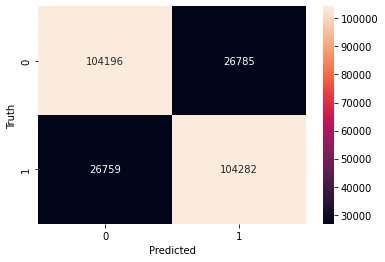

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn

cm = confusion_matrix(y_test, y_pred_bool)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
y_pred_eval = model2.predict(X_eval)
y_pred_eval_bool = (y_pred_eval > selected_thresh).astype("int32")
eval_pred_list = list(np.squeeze(y_pred_eval_bool))

In [ ]:
import csv
predfilename = 'eval_1_4.csv'
with open(predfilename, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["tweet_index", "target"])
    writer.writerows(zip(eval_tweet_index, eval_pred_list))

In [ ]:
from google.colab import files
files.download(predfilename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test Score: 0.47834208607673645
Test Accuracy: 0.7803314328193665


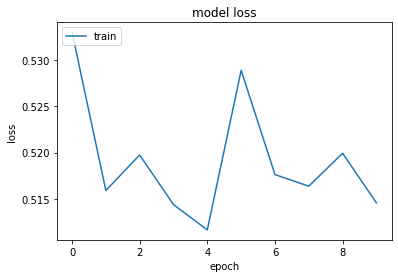

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Training for 10 more epochs

In [ ]:
history_2 = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.0)

Epoch 1/10
8189/8189 [==============================] - 166s 20ms/step - loss: 0.3950 - acc: 0.8233
Epoch 2/10
8189/8189 [==============================] - 165s 20ms/step - loss: 0.3934 - acc: 0.8238
Epoch 3/10
8189/8189 [==============================] - 164s 20ms/step - loss: 0.3917 - acc: 0.8251
Epoch 4/10
8189/8189 [==============================] - 164s 20ms/step - loss: 0.3905 - acc: 0.8256
Epoch 5/10
8189/8189 [==============================] - 165s 20ms/step - loss: 0.3892 - acc: 0.8261
Epoch 6/10
8189/8189 [==============================] - 165s 20ms/step - loss: 0.3878 - acc: 0.8270
Epoch 7/10
8189/8189 [==============================] - 165s 20ms/step - loss: 0.3865 - acc: 0.8276
Epoch 8/10
8189/8189 [==============================] - 165s 20ms/step - loss: 0.3861 - acc: 0.8276
Epoch 9/10
8189/8189 [==============================] - 165s 20ms/step - loss: 0.3841 - acc: 0.8290
Epoch 10/10
8189/8189 [==============================] - 165s 20ms/step - loss: 0.3833 - acc: 0.8296

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

8189/8189 [==============================] - 53s 7ms/step - loss: 0.4317 - acc: 0.8076


In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)

In [ ]:
num_test_zeros = (y_test == 0).sum()
num_pred_zeros = {}
for thresh in np.arange(0.3, 1.0, 0.01):
    y_pred_bool = (y_pred > thresh).astype("int32")
    num_pred_zeros[thresh] = (y_pred_bool == 0).sum()
threshs = list(num_pred_zeros.keys())
min_thresh_index = np.argmin(np.abs(list(num_pred_zeros.values()) - num_test_zeros))
selected_thresh = threshs[min_thresh_index]
print("Best threshold is :", selected_thresh)

y_pred_bool = (y_pred > selected_thresh).astype("int32")
print(classification_report(y_test, y_pred_bool))

Best threshold is : 0.5100000000000002
              precision    recall  f1-score   support

           0       0.81      0.81      0.81    130981
           1       0.81      0.81      0.81    131041

    accuracy                           0.81    262022
   macro avg       0.81      0.81      0.81    262022
weighted avg       0.81      0.81      0.81    262022



Text(33.0, 0.5, 'Truth')

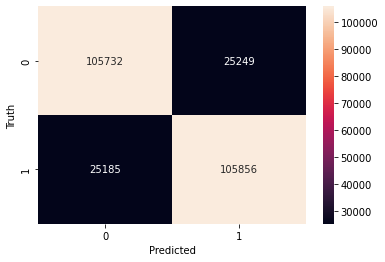

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn

cm = confusion_matrix(y_test, y_pred_bool)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
y_pred_eval = model.predict(X_eval)
y_pred_eval_bool = (y_pred_eval > selected_thresh).astype("int32")
eval_pred_list = list(np.squeeze(y_pred_eval_bool))

In [ ]:
import csv
with open('eval_1_3_v2.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["tweet_index", "target"])
    writer.writerows(zip(eval_tweet_index, eval_pred_list))

Test Score: 0.4317189157009125
Test Accuracy: 0.8076077699661255


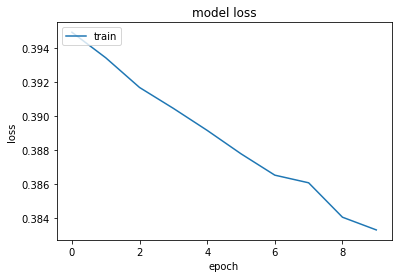

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.plot(history_2.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()